# TCGA COAD/READ Subtyping
In this analysis want to see if our cancer-specific oncRNAs are predictive of cancer subtypes.
For colorectal cancers, subtypes can be determined by consensus molecular subtypes (CMS).
CMS calls can be retrived from Sage Bionetworks Synapse. Metadata file is called 
`crc_clinical_molecular_public_all.txt`

In [1]:
import json as js
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib
from decimal import Decimal
from statsmodels.stats.multitest import fdrcorrection
import pymongo
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold 
from sklearn.utils import class_weight
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import json as js
from xgboost import XGBClassifier
import xgboost 
import joblib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
path = "/rumi/shams/jwang/TCGA_oncRNA"

# Load Metadata

In [3]:
tcga_metadata = pd.read_csv(f"{path}/metadata/TCGA_metadata.csv")
tcga_metadata["sample_id"] = tcga_metadata["TCGAbarcode"].apply(lambda x: x[0:12])
tcga_metadata = tcga_metadata.set_index("sample_id", drop=False)
crc_metadata = tcga_metadata[(tcga_metadata["TCGA_abb"].str.contains("COAD")) | (tcga_metadata["TCGA_abb"].str.contains("READ")) ]
crc_metadata = crc_metadata[~crc_metadata["Sample"].str.contains("normal")] #Miss normal samples
print(crc_metadata.shape)
clinical = pd.read_csv(f"{path}/metadata/crc_clinical_molecular_public_all.txt", sep="\t")

(619, 6)


In [4]:
crc_merge = pd.merge(tcga_metadata, clinical, left_index=True, right_on="sample")
print(crc_merge.shape)

(574, 25)


In [5]:
crc_merge[crc_merge["cms_label"] == "NOLBL"].shape #Lets remove the cancer samples without labels

(60, 25)

In [6]:
crc_merge = crc_merge[~crc_merge["cms_label"].str.contains("NOLBL")]
crc_merge = crc_merge.set_index("TCGAbarcode", drop=False)
print(crc_merge.shape) #Should be 514
crc_merge.head(2)

(514, 25)


,UUID,TCGAbarcode,TSS,Sample,TCGA_abb,sample_id,sample,dataset,age,gender,...,grade,msi,cimp,kras_mut,braf_mut,cms_label,osMo,osStat,rfsMo,rfsStat
TCGAbarcode,,,,,,,,,,,,,,,,,,,,,
TCGA-DY-A1H8-01A-21H-A154-13,a376f444-88be-4c9b-ad6d-1469428581eb,TCGA-DY-A1H8-01A-21H-A154-13,rectum adenocarcinoma,primary solid tumor,READ,TCGA-DY-A1H8,TCGA-DY-A1H8,tcga,77.0,female,...,NaN,mss,NaN,1.0,0.0,CMS2,32.580822,1.0,NaN,NaN
TCGA-AD-6890-01A-11H-1927-13,b5e61887-79fd-44e7-ac34-3084c1f9d22f,TCGA-AD-6890-01A-11H-1927-13,colon adenocarcinoma,primary solid tumor,COAD,TCGA-AD-6890,TCGA-AD-6890,tcga,65.0,male,...,NaN,mss,CIMP.High,0.0,0.0,CMS2,0.789041,0.0,NaN,NaN


# Load Data

In [7]:
sig_coad = pd.read_csv(f"{path}/results/fisher/post_filter/COAD_fisher.filter.csv", index_col=0)
sig_coad = sig_coad[sig_coad["fdr"] <= 0.1]
sig_read = pd.read_csv(f"{path}/results/fisher/post_filter/READ_fisher.filter.csv", index_col=0)
sig_read = sig_read[sig_read["fdr"] <= 0.1]
sig_read.head()

,pval,fdr
chr10:100114231-100114316:-,0.001687,0.010810
chr10:100134991-100135028:-,0.000012,0.000162
chr10:100235703-100235855:-,0.000058,0.000640
chr10:100346459-100346488:-,0.024156,0.093606
chr10:100346968-100346998:-,0.020176,0.082373


In [8]:
crc_oncRNAs = set()
crc_oncRNAs.update(sig_read.index.tolist())
crc_oncRNAs.update(sig_coad.index.tolist())
len(crc_oncRNAs)

57171

In [9]:
myclient=pymongo.MongoClient(port=27027)
mydb = myclient["TCGA_loci"]
rnacol = mydb["oncRNA_fil"]
rnacol.estimated_document_count()

261479

In [10]:
crc_merge["Order"] = np.arange(514)
crc_dict_order = dict(zip(crc_merge["TCGAbarcode"], crc_merge["Order"]))
len(crc_dict_order)

514

In [11]:
%%time
data = np.zeros((514, 57171))
binary_data = np.zeros((514, 57171))
cursor = rnacol.find(no_cursor_timeout=True)
oncRNA_order = []
j = 0
for rna in cursor:
    locus = rna["_id"]["locus"]
    if locus in crc_oncRNAs:
        oncRNA_order.append(locus)
        for s in rna["samples"]:
            barcode = s["study"]
            if barcode in crc_dict_order:
                i = crc_dict_order[barcode]
                data[i,j] = s["cpm"]
                binary_data[i,j] = 1
        j += 1
cursor.close()

CPU times: user 3min 5s, sys: 3.79 s, total: 3min 9s
Wall time: 3min 18s


In [12]:
data_df = pd.DataFrame(data, index=crc_merge["TCGAbarcode"].tolist(), columns=oncRNA_order)
binary_data_df = pd.DataFrame(binary_data, index=crc_merge["TCGAbarcode"].tolist(), columns=oncRNA_order)
data_df.head(1)

,chr10:100092234-100092264:+,chr10:100114231-100114316:-,chr10:100134991-100135028:-,chr10:100138905-100138944:-,chr10:100235703-100235855:-,chr10:100253527-100253587:-,chr10:100346459-100346488:-,chr10:100346968-100346998:-,chr10:100360757-100360789:+,chr10:100364990-100365017:+,...,chrY:8039391-8039413:-,chrY:8095654-8095701:-,chrY:8787565-8787615:+,chrY:8838622-8838652:-,chrY:8869634-8869689:-,chrY:9278099-9278135:-,chrY:9655265-9655330:+,chrY:9708993-9709034:-,chrY:9801672-9801728:-,chrY_KI270740v1_random:23109-23159:-
TCGA-DY-A1H8-01A-21H-A154-13,0.0,0.0,0.093947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
binary_data_df.head(1)

,chr10:100092234-100092264:+,chr10:100114231-100114316:-,chr10:100134991-100135028:-,chr10:100138905-100138944:-,chr10:100235703-100235855:-,chr10:100253527-100253587:-,chr10:100346459-100346488:-,chr10:100346968-100346998:-,chr10:100360757-100360789:+,chr10:100364990-100365017:+,...,chrY:8039391-8039413:-,chrY:8095654-8095701:-,chrY:8787565-8787615:+,chrY:8838622-8838652:-,chrY:8869634-8869689:-,chrY:9278099-9278135:-,chrY:9655265-9655330:+,chrY:9708993-9709034:-,chrY:9801672-9801728:-,chrY_KI270740v1_random:23109-23159:-
TCGA-DY-A1H8-01A-21H-A154-13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Subtype Association

In [14]:
subtype_count = crc_merge.groupby("cms_label", as_index=False).size()
subtype_count = dict(zip(subtype_count["cms_label"], subtype_count["size"]))
subtype_count

{'CMS1': 78, 'CMS2': 219, 'CMS3': 71, 'CMS4': 146}

In [15]:
pval_results = {}
for j in range(len(oncRNA_order)):
    rna = oncRNA_order[j]
    tumor_subtype_dict= {"CMS1":[], "CMS2":[], "CMS3":[], "CMS4":[]}
    
    for i, barcode, subtype in zip(crc_merge["Order"], crc_merge["TCGAbarcode"], crc_merge["cms_label"]):
        tumor_subtype_dict[subtype].append(data[i,j])
    test = scipy.stats.f_oneway(tumor_subtype_dict["CMS1"], tumor_subtype_dict["CMS2"], tumor_subtype_dict["CMS3"], 
                                tumor_subtype_dict["CMS4"])
    pval_results[rna] = {"pval":test.pvalue, "data":tumor_subtype_dict}

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/scipy/stats/stats.py:3641: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [16]:
pval_results_df = pd.DataFrame(pval_results).T
rej, fdr = fdrcorrection(pval_results_df["pval"], alpha=0.1)
pval_results_df["fdr"] = fdr  

In [17]:
sig_results = pval_results_df[pval_results_df["fdr"] <= 0.1].sort_values("fdr")
sig_results.head()

,pval,data,fdr
chr20:9357012-9357046:+,0.0,"{'CMS1': [0.0, 0.0, 0.0, 0.0702695899846721, 0...",0.000001
chr8:39917875-39917980:+,0.0,"{'CMS1': [0.5077015791042215, 0.0, 0.0, 0.0, 0...",0.000001
chr4:6693007-6693037:+,0.0,"{'CMS1': [0.0, 0.0, 0.0, 0.1405391799693442, 0...",0.000001
chr14:74382098-74382138:+,0.0,"{'CMS1': [0.0, 0.0, 0.0, 0.0, 0.0, 1.567370276...",0.000002
chr20:9333339-9333369:+,0.0,"{'CMS1': [0.7615523686563324, 0.29439645782181...",0.000002


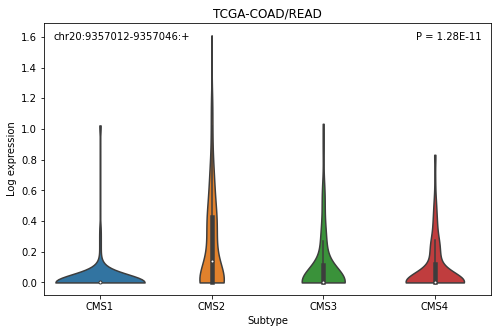

In [18]:
plt.figure(figsize=(8,5))
rna = sig_results.index[0]
tumor_subtype_dict = sig_results.loc[rna]["data"]
pval = sig_results.loc[rna]["pval"]
exp_data = []
subtype_data = []
order = ["CMS1", "CMS2", "CMS3", "CMS4"]
for subtype in order:
    exp_data.extend(tumor_subtype_dict[subtype])
    subtype_data.extend([subtype]*len(tumor_subtype_dict[subtype]))
data = pd.DataFrame(subtype_data, columns=["Subtype"])
data["RNA expression"] = exp_data
data["Log expression"] = np.log(data["RNA expression"] + 1)
sns.violinplot(x="Subtype", y="Log expression", data=data, scale="area", inner="box", cut=0)
plt.title("TCGA-COAD/READ")
ax = plt.gca()
ax.add_artist(AnchoredText(f"P = {'%.2E' % Decimal(pval)}", frameon=False, 
                            loc='upper right'))
ax.add_artist(AnchoredText(f"{rna}", frameon=False, 
                            loc='upper left'))
# plt.savefig("figures/subtype_assoc_oncRNA1.pdf")

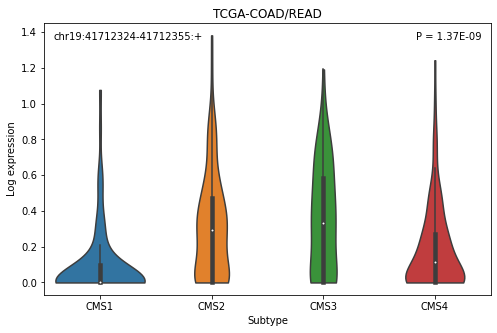

In [19]:
plt.figure(figsize=(8,5))
rna = sig_results.index[9]
tumor_subtype_dict = sig_results.loc[rna]["data"]
pval = sig_results.loc[rna]["pval"]
exp_data = []
subtype_data = []
order = ["CMS1", "CMS2", "CMS3", "CMS4"]
for subtype in order:
    exp_data.extend(tumor_subtype_dict[subtype])
    subtype_data.extend([subtype]*len(tumor_subtype_dict[subtype]))
data = pd.DataFrame(subtype_data, columns=["Subtype"])
data["RNA expression"] = exp_data
data["Log expression"] = np.log(data["RNA expression"] + 1)
sns.violinplot(x="Subtype", y="Log expression", data=data, scale="area", inner="box", cut=0)
plt.title("TCGA-COAD/READ")
ax = plt.gca()
ax.add_artist(AnchoredText(f"P = {'%.2E' % Decimal(pval)}", frameon=False, 
                            loc='upper right'))
ax.add_artist(AnchoredText(f"{rna}", frameon=False, 
                            loc='upper left'))
# plt.savefig("figures/subtype_assoc_oncRNA1.pdf")

# Heatmap of Subtype Different oncRNAs

In [20]:
sig_oncRNAs = data_df[sig_results.index].T
print(sig_oncRNAs.shape)
sig_oncRNAs.head()

(1217, 514)


,TCGA-DY-A1H8-01A-21H-A154-13,TCGA-AD-6890-01A-11H-1927-13,TCGA-CA-6719-01A-11H-1838-13,TCGA-CM-4743-01A-01T-1722-13,TCGA-AG-A008-01A-21R-A076-13,TCGA-DC-4749-01A-01T-1735-13,TCGA-AG-A016-01A-21R-A076-13,TCGA-F4-6807-01A-11H-1838-13,TCGA-AA-A024-01A-11R-A076-13,TCGA-AA-3678-01A-01T-0906-13,...,TCGA-AG-A026-01A-32R-A082-13,TCGA-A6-2681-01A-01T-1409-13,TCGA-D5-6927-01A-21H-1927-13,TCGA-F4-6806-01A-11H-1838-13,TCGA-AA-A01R-01A-21R-A082-13,TCGA-AA-3860-01A-02T-0906-13,TCGA-AZ-6603-01A-11H-1838-13,TCGA-CM-5349-01A-21H-1722-13,TCGA-D5-6530-01A-11H-1722-13,TCGA-AD-6901-01A-11H-1927-13
chr20:9357012-9357046:+,0.000000,0.218397,0.122314,0.000000,0.00000,0.000000,0.56830,0.063185,0.0,0.596894,...,0.458823,0.317427,0.000000,0.14662,0.0,0.000000,0.221881,0.089364,0.000000,0.213885
chr8:39917875-39917980:+,0.093947,0.000000,0.000000,0.507702,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
chr4:6693007-6693037:+,0.000000,0.000000,0.163086,0.000000,0.49111,0.098161,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.14662,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
chr14:74382098-74382138:+,0.093947,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.596894,...,0.000000,0.000000,0.362049,0.00000,0.0,0.761241,0.000000,0.000000,0.177675,0.000000
chr20:9333339-9333369:+,0.000000,0.218397,0.163086,0.761552,1.47333,0.098161,1.42075,0.252741,0.0,6.565835,...,0.000000,2.221986,0.000000,0.00000,0.0,0.761241,3.550088,0.714913,0.000000,0.320827


In [21]:
colData = pd.DataFrame(sig_oncRNAs.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Subtype"] = crc_merge["cms_label"].tolist()
colData = colData.sort_values("Subtype") #First sort by cell line then by subtype
colData = colData.set_index("Subtype", drop=False)
colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [22]:
colData

,Sample,Subtype
Subtype,,
CMS1,TCGA-DM-A1HB-01A-21H-A17X-13,CMS1
CMS1,TCGA-AU-6004-01A-11H-1722-13,CMS1
CMS1,TCGA-F5-6814-01A-31H-1927-13,CMS1
CMS1,TCGA-CM-5861-01A-01T-1652-13,CMS1
CMS1,TCGA-AA-3877-01A-01T-1021-13,CMS1
...,...,...
CMS4,TCGA-G4-6314-01A-11H-1722-13,CMS4
CMS4,TCGA-F4-6805-01A-11H-1838-13,CMS4
CMS4,TCGA-D5-6541-01A-11H-1722-13,CMS4


In [23]:
#Max norm
loci_df = np.zeros(sig_oncRNAs.shape)
for i in range(sig_oncRNAs.shape[0]):
    max_per_row = np.percentile(sig_oncRNAs.iloc[i], 99)
    if max_per_row == 0:
        max_per_row = max(sig_oncRNAs.iloc[i])
    loci_df[i] = np.divide(sig_oncRNAs.iloc[i], max_per_row) #Max-norm

In [24]:
loci_df = pd.DataFrame(loci_df, index=sig_oncRNAs.index, columns=sig_oncRNAs.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

<Figure size 1440x1440 with 0 Axes>

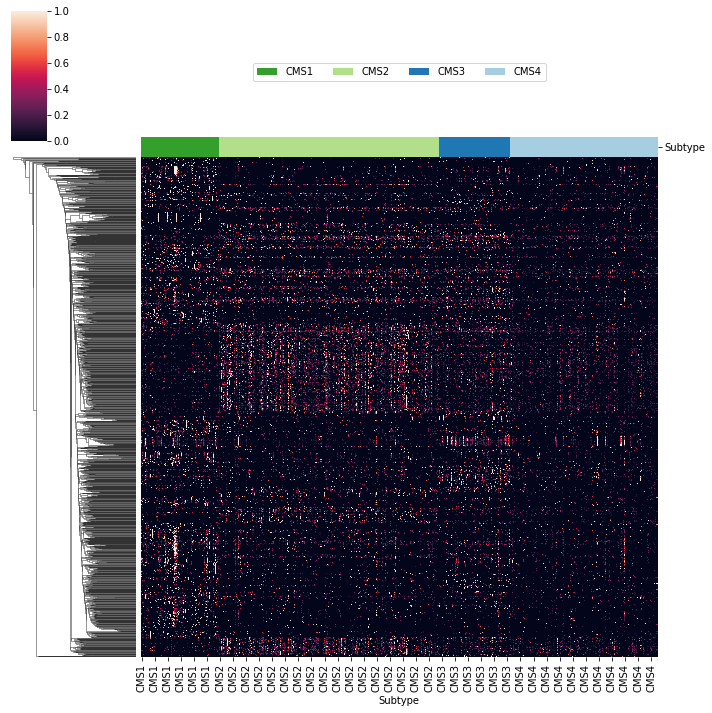

In [25]:
plt.figure(figsize=(20,20))
g=sns.clustermap(loci_df, col_cluster=False, row_cluster=True, col_colors=col_colors,yticklabels=False, method="average", rasterized=True, vmax=1)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
# g.savefig("figures/cell_lines_all_sig_loci_heatmap.pdf")

## Binary

In [26]:
binary_df = binary_data_df[sig_results.index].T
print(binary_df.shape)
binary_df.head(2)

(1217, 514)


,TCGA-DY-A1H8-01A-21H-A154-13,TCGA-AD-6890-01A-11H-1927-13,TCGA-CA-6719-01A-11H-1838-13,TCGA-CM-4743-01A-01T-1722-13,TCGA-AG-A008-01A-21R-A076-13,TCGA-DC-4749-01A-01T-1735-13,TCGA-AG-A016-01A-21R-A076-13,TCGA-F4-6807-01A-11H-1838-13,TCGA-AA-A024-01A-11R-A076-13,TCGA-AA-3678-01A-01T-0906-13,...,TCGA-AG-A026-01A-32R-A082-13,TCGA-A6-2681-01A-01T-1409-13,TCGA-D5-6927-01A-21H-1927-13,TCGA-F4-6806-01A-11H-1838-13,TCGA-AA-A01R-01A-21R-A082-13,TCGA-AA-3860-01A-02T-0906-13,TCGA-AZ-6603-01A-11H-1838-13,TCGA-CM-5349-01A-21H-1722-13,TCGA-D5-6530-01A-11H-1722-13,TCGA-AD-6901-01A-11H-1927-13
chr20:9357012-9357046:+,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
chr8:39917875-39917980:+,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
binary_df = binary_df[list(colData["Sample"])] #Set columns to match colData order
binary_df.columns = colData["Subtype"]

<Figure size 1440x1440 with 0 Axes>

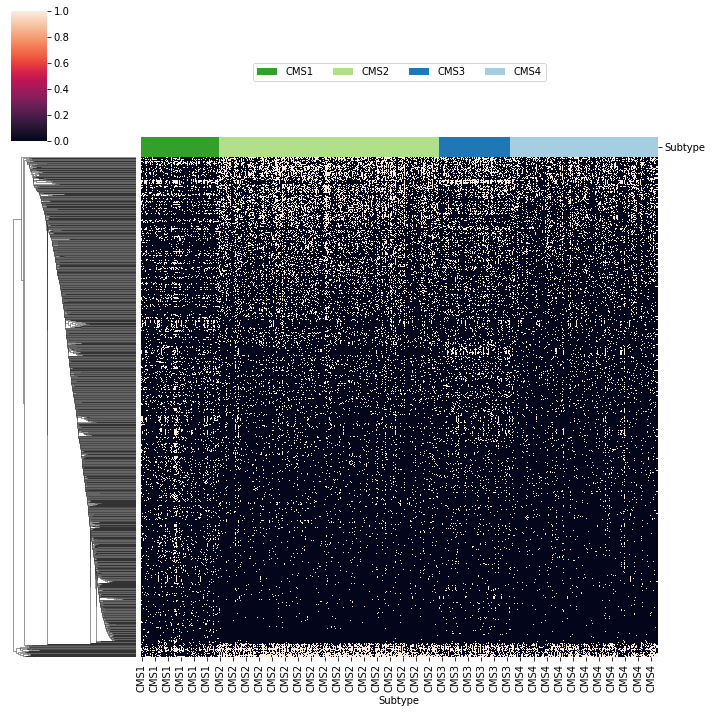

In [28]:
plt.figure(figsize=(20,20))
g=sns.clustermap(binary_df, col_cluster=False, row_cluster=True, col_colors=col_colors,yticklabels=False, method="average", rasterized=True)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
# g.savefig("figures/cell_lines_all_sig_loci_heatmap.pdf")

# Classifier
I'm interested to see if we can use our oncRNAs as a CMS classifier seeing that https://www.nature.com/articles/s41598-017-16747-x used the genes to create their CMScaller.

In [29]:
X = data_df[loci_df.index].apply(np.ceil)
Y = crc_merge.loc[X.index]["cms_label"].tolist()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, stratify=Y)

In [31]:
labels = ["CMS1", "CMS2", "CMS3", "CMS4"]
class_weights = class_weight.compute_class_weight("balanced", labels, y_train)
class_weight_map = {}
for i in range(len(labels)):
    class_weight_map[labels[i]] = class_weights[i] 
sample_weights = []
for y in y_train:
    sample_weights.append(class_weight_map[y])

In [32]:
xgb_model = XGBClassifier(silent=False,n_estimators=100, random_state=37, max_depth=3)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

[17:48:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=37, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=False, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
y_pred = xgb_model.predict(X_train)
acc = accuracy_score(y_train, y_pred)      
acc

1.0

In [34]:
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)      
acc

0.6796116504854369

In [35]:
y_pred = xgb_model.predict(X_test)

In [36]:
print(classification_report(y_pred, y_test, labels=labels))

              precision    recall  f1-score   support

        CMS1       0.69      0.61      0.65        18
        CMS2       0.80      0.78      0.79        45
        CMS3       0.57      0.73      0.64        11
        CMS4       0.55      0.55      0.55        29

    accuracy                           0.68       103
   macro avg       0.65      0.67      0.66       103
weighted avg       0.68      0.68      0.68       103



In [37]:
confusion_matrix(y_pred, y_test, labels=labels)

array([[11,  0,  3,  4],
       [ 1, 35,  1,  8],
       [ 1,  1,  8,  1],
       [ 3,  8,  2, 16]])

<AxesSubplot:>

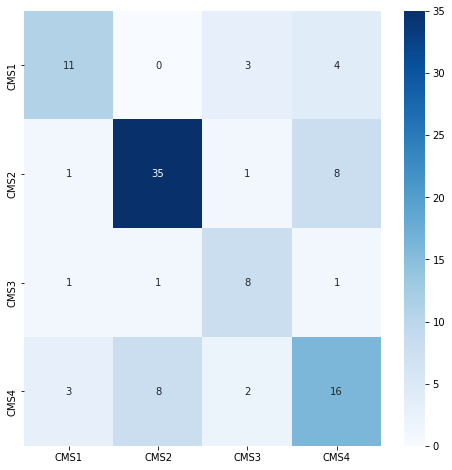

In [38]:
cm = confusion_matrix(y_pred, y_test, labels=labels)
cm = np.around(cm, 3)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)

CMS2 and CMS 4 prediction performs better, but also probably a result of class imbalance.

<AxesSubplot:>

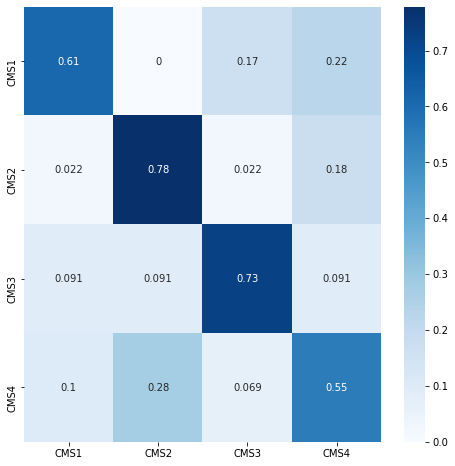

In [39]:
row_norm_cm = confusion_matrix(y_pred, y_test, labels=labels, normalize="true") #Normalizes by True rows (measure of precision)
row_norm_cm = np.around(row_norm_cm, 3)
plt.figure(figsize=(8,8))
sns.heatmap(row_norm_cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)

<AxesSubplot:>

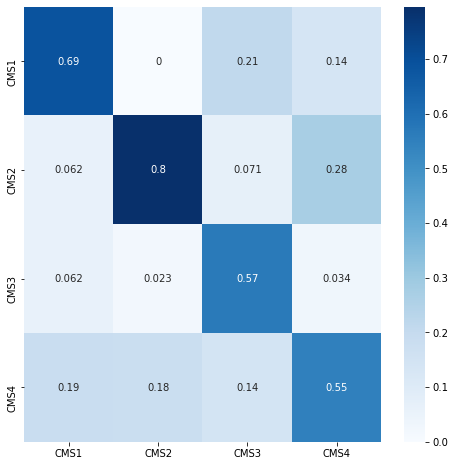

In [40]:
norm_cm = confusion_matrix(y_pred, y_test, labels=labels, normalize="pred")
norm_cm = np.around(norm_cm, 3)
plt.figure(figsize=(8,8))
sns.heatmap(norm_cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)

# Conclusion